In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
df = pd.read_csv('data/TopAnimatedImDb.csv')

In [4]:
df.head()

,Title,Rating,Votes,Gross,Genre,Metascore,Certificate,Director,Year,Description,Runtime
0,Sen to Chihiro no kamikakushi,8.6,"747,148",$10.06M,"Adventure, Family",96.0,U,Hayao Miyazaki,2001,"[""\nDuring her family's move to the suburbs, a...",125 min
1,The Lion King,8.5,"1,041,158",$422.78M,"Adventure, Drama",88.0,U,Roger Allers,1994,['\nLion prince Simba and his father are targe...,88 min
2,Hotaru no haka,8.5,"272,469",NaN,"Drama, War",94.0,U,Isao Takahata,1988,['\nA young boy and his little sister struggle...,89 min
3,Kimi no na wa.,8.4,"259,975",$5.02M,"Drama, Fantasy",79.0,U,Makoto Shinkai,2016,['\nTwo strangers find themselves linked in a ...,106 min
4,Spider-Man: Into the Spider-Verse,8.4,"510,227",$190.24M,"Action, Adventure",87.0,U,Bob Persichetti,2018,['\nTeen Miles Morales becomes the Spider-Man ...,117 min


In [5]:
df.info()#Reviewing the type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        85 non-null     object 
 1   Rating       85 non-null     float64
 2   Votes        85 non-null     object 
 3   Gross        50 non-null     object 
 4   Genre        85 non-null     object 
 5   Metascore    80 non-null     float64
 6   Certificate  84 non-null     object 
 7   Director     85 non-null     object 
 8   Year         85 non-null     int64  
 9   Description  85 non-null     object 
 10  Runtime      85 non-null     object 
dtypes: float64(2), int64(1), object(8)
memory usage: 7.4+ KB


In [6]:
df.isna().values.any()#Review Nan


True

In [7]:
df.duplicated().values.any()#Check for duplicates

False

In [8]:
print(df.isnull().any())#Finding Nana


Title          False
Rating         False
Votes          False
Gross           True
Genre          False
Metascore       True
Certificate     True
Director       False
Year           False
Description    False
Runtime        False
dtype: bool


## Preprocessing Data


In [9]:
df.Runtime

0     125 min
1      88 min
2      89 min
3     106 min
4     117 min
       ...   
80     92 min
81     88 min
82     83 min
83     78 min
84     83 min
Name: Runtime, Length: 85, dtype: object

In [10]:
#Cleaning Runtime to compare
df.Runtime = df.Runtime.astype(str).str.replace(' min', '')
df.Runtime = pd.to_numeric(df.Runtime)
df.Runtime

0     125
1      88
2      89
3     106
4     117
     ... 
80     92
81     88
82     83
83     78
84     83
Name: Runtime, Length: 85, dtype: int64

In [11]:
df.Votes = df.Votes.astype(str).str.replace(',', '')
df.Gross = df.Gross.astype(str).str.replace('$', '')
df.Gross = df.Gross.astype(str).str.replace('M', '')

df.Votes = pd.to_numeric(df.Votes)
df.Gross =df.Gross.astype(float)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        85 non-null     object 
 1   Rating       85 non-null     float64
 2   Votes        85 non-null     int64  
 3   Gross        50 non-null     float64
 4   Genre        85 non-null     object 
 5   Metascore    80 non-null     float64
 6   Certificate  84 non-null     object 
 7   Director     85 non-null     object 
 8   Year         85 non-null     int64  
 9   Description  85 non-null     object 
 10  Runtime      85 non-null     int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.4+ KB


## Initial Analysis


In [13]:
print(f'The average duration of the Top animated movies is: {df.Runtime.mean()} min')
# print(f'The longest movie of the Top animated movies is: {df.Runtime.ma? min')

The average duration of the Top animated movies is: 99.3529411764706 min


In [14]:
df.sort_values(by = 'Runtime', ascending = False)[:5] #Not the longest anymore because Spiderman is out!

,Title,Rating,Votes,Gross,Genre,Metascore,Certificate,Director,Year,Description,Runtime
27,Kaguya-hime no Monogatari,8.0,46319,NaN,"Drama, Family",89.0,U,Isao Takahata,2013,['\nFound inside a shining stalk of bamboo by ...,137
7,Mononoke-hime,8.4,388925,2.38,"Adventure, Fantasy",76.0,U,Hayao Miyazaki,1997,"[""\nOn a journey to find the cure for a Tatari...",134
15,Koe no katachi,8.1,78876,NaN,Drama,78.0,16,Naoko Yamada,2016,['\nA young man is ostracized by his classmate...,130
59,Kaze tachinu,7.7,85123,5.21,"Biography, Drama",83.0,Not Rated,Hayao Miyazaki,2013,"['\nA look at the life of Jiro Horikoshi, the ...",126
0,Sen to Chihiro no kamikakushi,8.6,747148,10.06,"Adventure, Family",96.0,U,Hayao Miyazaki,2001,"[""\nDuring her family's move to the suburbs, a...",125


In [15]:
df.Certificate.unique()#Finding categories

array(['U', 'UA', '16', '7', nan, 'PG', 'PG-13', 'Not Rated', 'A', 'R',
       '13'], dtype=object)

In [16]:
categories = df.Certificate.value_counts()
categories

Certificate
U            60
UA            8
PG            4
PG-13         3
A             3
Not Rated     2
16            1
7             1
R             1
13            1
Name: count, dtype: int64

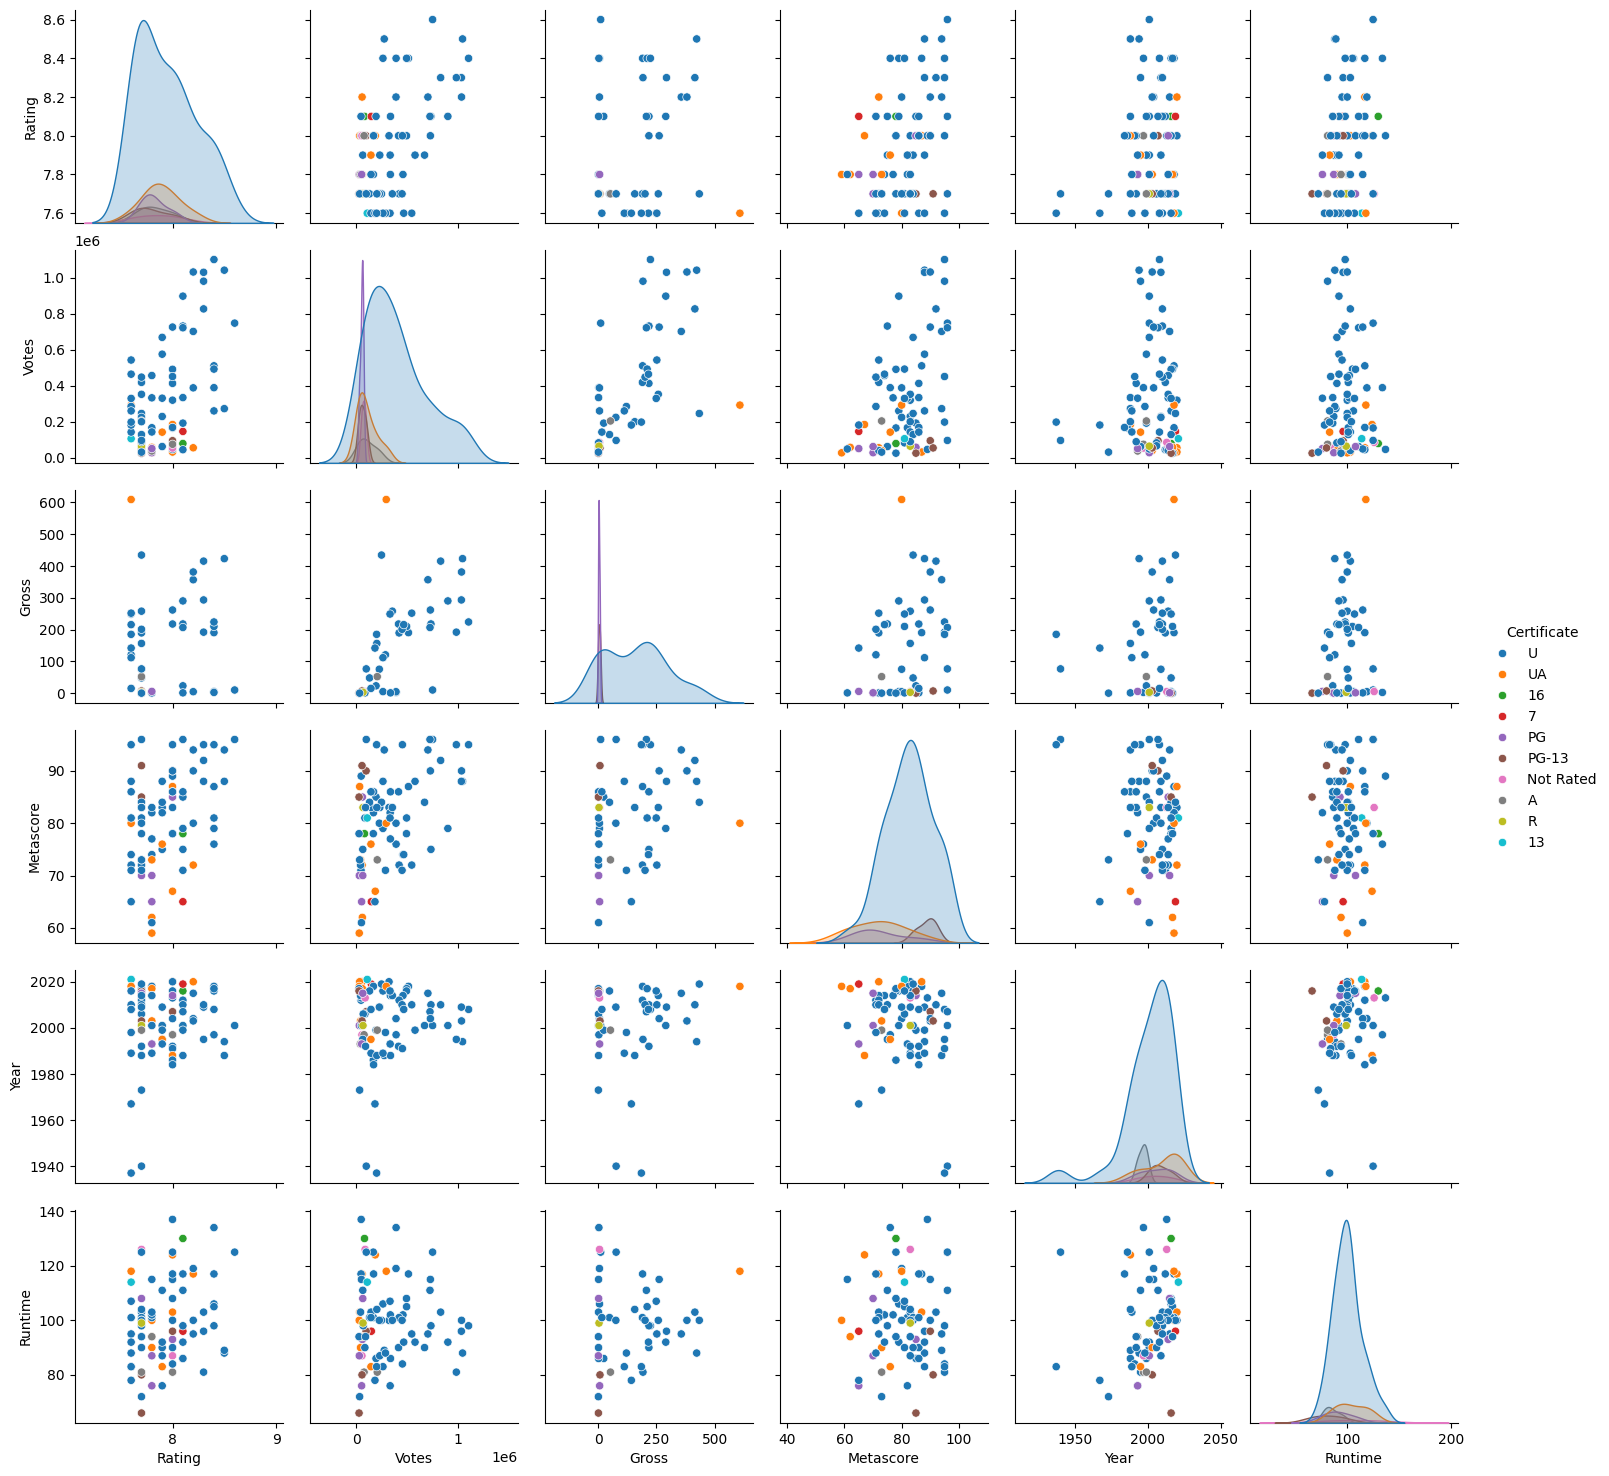

In [17]:
sns.pairplot(data=df, hue = "Certificate")


In [18]:
rvotes = px.bar(df, x ='Rating', y ='Votes', color= 'Rating', hover_data='Title')
rvotes.show()

In [19]:
rgross = px.bar(df, x = 'Rating', y = 'Gross', hover_data=["Title"], color = 'Rating')
rgross.show()

In [20]:
genresn = df.Genre.value_counts()
genresn

Genre
 Adventure, Comedy     30
 Action, Adventure     14
 Adventure, Family      7
 Drama, Family          6
 Drama, Fantasy         4
 Family, Fantasy        3
 Comedy, Drama          3
 Adventure, Drama       3
 Action, Crime          2
 Biography, Drama       2
 Action, Drama          2
 Comedy, Fantasy        1
 Biography, Crime       1
 Adventure, Sci-Fi      1
 Comedy, Family         1
 Crime, Drama           1
 Drama                  1
 Adventure, Fantasy     1
 Drama, War             1
 Sci-Fi                 1
Name: count, dtype: int64

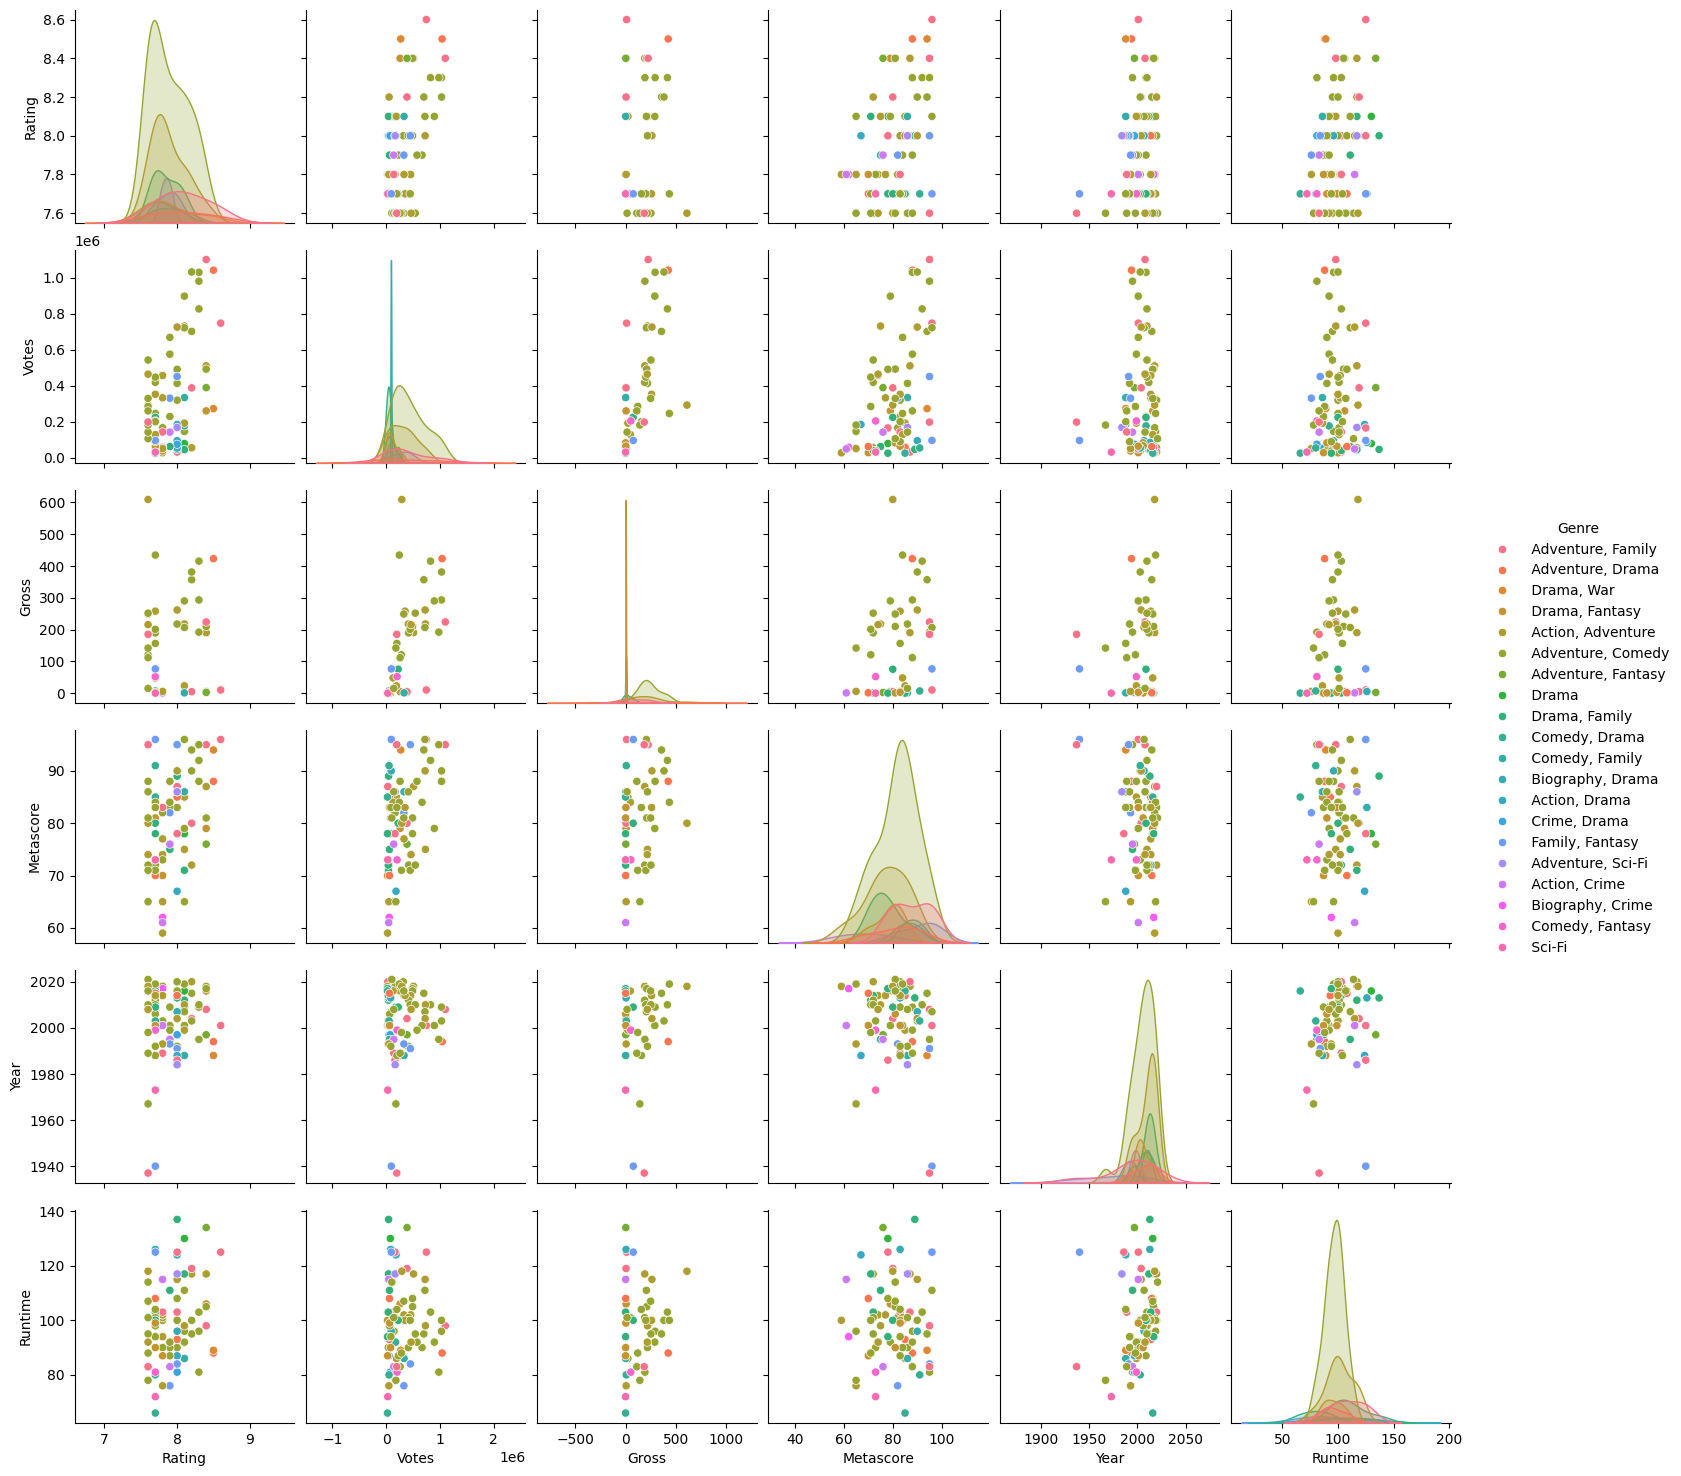

In [21]:
sns.pairplot(data=df, hue = "Genre")


In [22]:
fig = px.scatter(df, x="Director", y="Rating",
                 color="Director",
                 hover_data=['Title'], size ='Year', width=1000, height=600)

fig.update(layout_showlegend=False)

fig.show()

In [23]:
fig = px.scatter(df, x="Director", y="Genre",
                 color="Director",
                 hover_data=['Title'], size ='Year', width=1000, height=600)

fig.update(layout_showlegend=False)

fig.show()

<ipython-input-24-082e57a9fecd>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, 'U'),
 Text(1, 0, 'UA'),
 Text(2, 0, '16'),
 Text(3, 0, '7'),
 Text(4, 0, 'PG'),
 Text(5, 0, 'PG-13'),
 Text(6, 0, 'Not Rated'),
 Text(7, 0, 'A'),
 Text(8, 0, 'R'),
 Text(9, 0, '13')]

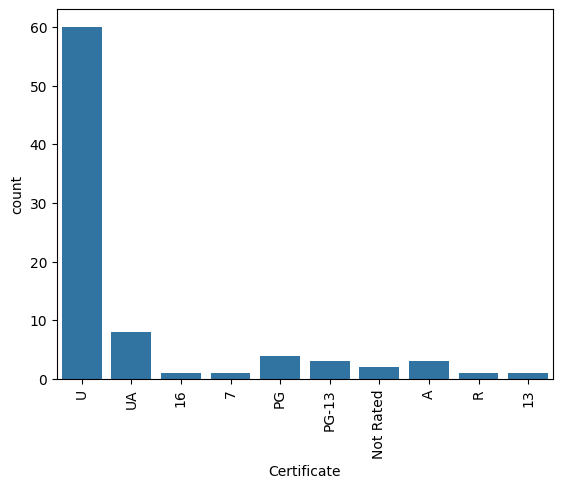

In [24]:
chart = sns.countplot(x=df["Certificate"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

<ipython-input-25-4cb4ab6400c4>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, ' Adventure, Family'),
 Text(1, 0, ' Adventure, Drama'),
 Text(2, 0, ' Drama, War'),
 Text(3, 0, ' Drama, Fantasy'),
 Text(4, 0, ' Action, Adventure'),
 Text(5, 0, ' Adventure, Comedy'),
 Text(6, 0, ' Adventure, Fantasy'),
 Text(7, 0, ' Drama'),
 Text(8, 0, ' Drama, Family'),
 Text(9, 0, ' Comedy, Drama'),
 Text(10, 0, ' Comedy, Family'),
 Text(11, 0, ' Biography, Drama'),
 Text(12, 0, ' Action, Drama'),
 Text(13, 0, ' Crime, Drama'),
 Text(14, 0, ' Family, Fantasy'),
 Text(15, 0, ' Adventure, Sci-Fi'),
 Text(16, 0, ' Action, Crime'),
 Text(17, 0, ' Biography, Crime'),
 Text(18, 0, ' Comedy, Fantasy'),
 Text(19, 0, ' Sci-Fi')]

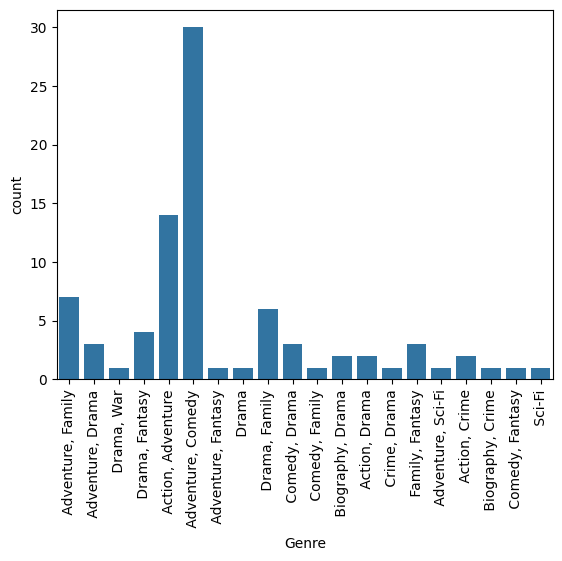

In [25]:
chart = sns.countplot(x=df["Genre"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

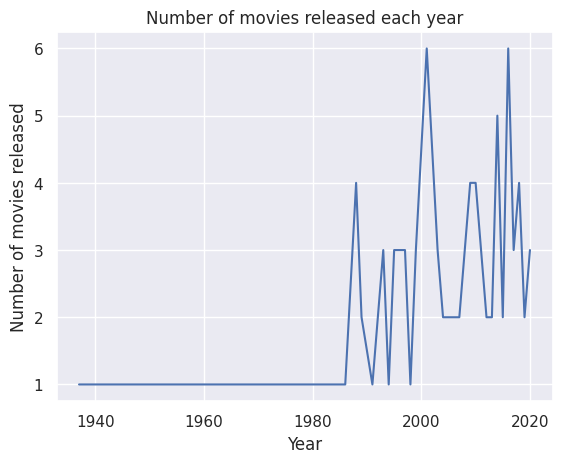

In [26]:
moviesyear = df.groupby('Year')['Title'].count()

# Create the line plot
sns.set(style="darkgrid")
plt.plot(moviesyear.index[:-1], moviesyear.values[:-1])
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released each year')
plt.show()

In [27]:
directorCount = df['Director'].value_counts()
display(directorCount.head(10))

Director
Hayao Miyazaki    10
Pete Docter        4
Satoshi Kon        4
Brad Bird          4
Ron Clements       3
Lee Unkrich        2
Andrew Stanton     2
Isao Takahata      2
Wes Anderson       2
Mark Osborne       2
Name: count, dtype: int64

In [28]:
fig = px.scatter(df, x="Director", y="Votes",
                 color="Director",
                 hover_data=['Title'], size ='Year', width=1000, height=600)

fig.update(layout_showlegend=False)

fig.show()

## Recommendations System


In [29]:
#Remove stop words
tfidf = TfidfVectorizer(stop_words='english')

In [30]:
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['Description'])

In [31]:
# Calculate the cosine similarity matrix, cosineSim is how similar and the tfidf is to know how relevant they are
cosineSim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosineSim.shape

(85, 85)

In [39]:
df.Genre.shape

(85,)

In [33]:
indices = pd.Series(df.index, index=df['Title'])

In [34]:
def getRecommendations(title, cosine_sim=cosineSim):
    indice = indices[title]

    # Get the similarity scores of all movies with that movie
    simScores = list(enumerate(cosine_sim[indice]))

    # Sort the movies based on the similarity scores
    simScores = sorted(simScores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top 10 similar movies
    simScores = simScores[1:11]

    # Get the indices
    movieIndices = [i[0] for i in simScores]

    # Return the top 10 most similar movies
    return df['Title'].iloc[movieIndices]

In [36]:
getRecommendations('The Iron Giant')

6                            WALL·E
2                    Hotaru no haka
61                   Wreck-It Ralph
79              Gake no ue no Ponyo
24                      WolfWalkers
1                     The Lion King
75    The Mitchells vs the Machines
36           Tenkû no shiro Rapyuta
55         Kubo and the Two Strings
47                       Big Hero 6
Name: Title, dtype: object

## Neural Networks


In [104]:
import tensorflow as ts
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [110]:
descriptions = df['Description'].values

tokenizer = Tokenizer(num_words=500)  # Adjust num_words as needed
tokenizer.fit_on_texts(descriptions)
sequences = tokenizer.texts_to_sequences(descriptions)

# Pad sequences to ensure uniform input length
max_len = 85  # Adjust max_len based on your data

X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
#One-Hot enconding genres

In [116]:
X = cosineSim

In [90]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Certificate'])

In [91]:
y_cat = to_categorical(y_encoded)

In [92]:
y_cat.shape

(85, 11)

In [117]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(85,)),  # Input shape matches the number of features
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),
       Dense(32, activation='relu'),  # Added another dense layer
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')  # Output layer with softmax activation
])

In [118]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
              metrics=['accuracy'])

In [119]:
history = model.fit(X, y_cat, epochs=50, batch_size=10, validation_split=0.2)


Epoch 1/50
7/7 [==============================] - 2s 112ms/step - loss: 2.4084 - accuracy: 0.0882 - val_loss: 2.3167 - val_accuracy: 0.6471
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 2.3035 - accuracy: 0.2206 - val_loss: 2.2480 - val_accuracy: 0.7059
Epoch 3/50
7/7 [==============================] - 0s 21ms/step - loss: 2.2188 - accuracy: 0.4118 - val_loss: 2.1664 - val_accuracy: 0.7059
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 2.0973 - accuracy: 0.5735 - val_loss: 2.0583 - val_accuracy: 0.7059
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 1.9818 - accuracy: 0.6029 - val_loss: 1.9151 - val_accuracy: 0.7059
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 1.8342 - accuracy: 0.6471 - val_loss: 1.7440 - val_accuracy: 0.7059
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 1.6571 - accuracy: 0.6618 - val_loss: 1.5665 - val_accuracy: 0.7059
Epoch 8/50
7/7 [==========

In [37]:
#df.budget = pd.to_numeric(df.budget, errors='coerce')
#df.box_office = pd.to_numeric(df.box_office, errors='coerce')#Replacing the Not Available with Nan

In [38]:
#genres_list = df.genre.str.split(",", expand = True)#Split the genres and creating a column for each
#genres_list = df['genre'].value_counts()#Cuantas peliculas hay por genero
#genres_list.unique()